In [1]:
%matplotlib inline


Variational Sparse GP for Binary Classification
===============================================

Here we fit the hyperparameters of a Gaussian Process by maximizing the (log)
marginal likelihood. This is commonly referred to as empirical Bayes, or
type-II maximum likelihood estimation.



In [2]:
import numpy as np

import tensorflow as tf
import tensorflow_probability as tfp

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from tensorflow.keras.layers import Layer, InputLayer
from tensorflow.keras.initializers import Identity, Constant

from etudes.initializers import KMeans, RandomSubset
from etudes.datasets import make_classification_dataset
from etudes.plotting import fill_between_stddev
from etudes.utils import get_kl_weight, DistributionPair

from collections import defaultdict

In [3]:
# shortcuts
tfd = tfp.distributions
kernels = tfp.math.psd_kernels


# constants
num_train = 500  # nbr training points in synthetic dataset
num_test = 500
num_features = 2  # dimensionality
num_index_points = 256  # nbr of index points
num_samples = 25
quadrature_size = 20

num_inducing_points = 50
num_epochs = 2000
batch_size = 64
shuffle_buffer_size = 500

jitter = 1e-6

kernel_cls = kernels.MaternFiveHalves

seed = 8888  # set random seed for reproducibility
random_state = np.random.RandomState(seed)

x_min, x_max = 0.0, 1.0
y_min, y_max = -6.0, 4.0

# index points
X_q = np.linspace(x_min, x_max, num_index_points).reshape(-1, num_features)

golden_ratio = 0.5 * (1 + np.sqrt(5))

In [4]:
def golden_size(width):
    return (width, width / golden_ratio)

In [5]:
rc = {
    "figure.figsize": golden_size(10),
    "font.serif": ['Times New Roman'],
    "text.usetex": True,
}

In [6]:
sns.set(context="notebook",
        style="ticks",
        palette="colorblind",
        font="serif",
        rc=rc)

In [7]:
train = tfd.MixtureSameFamily(
    mixture_distribution=tfd.Categorical(probs=[0.5, 0.5]),
    components_distribution=tfd.MultivariateNormalDiag(
        loc=[[-2.0, 3.0], [2.0, 3.0]], scale_diag=[1.0, 2.0])
)
test = tfd.MixtureSameFamily(
    mixture_distribution=tfd.Categorical(probs=[0.5, 0.5]),
    components_distribution=tfd.MultivariateNormalDiag(
        loc=[[0.0, -1.0], [4.0, -1.0]])
)
pair = DistributionPair(test, train)

In [8]:
x2, x1 = np.mgrid[-4:9:50j,-6:8:50j]
X_q = np.dstack([x1, x2])

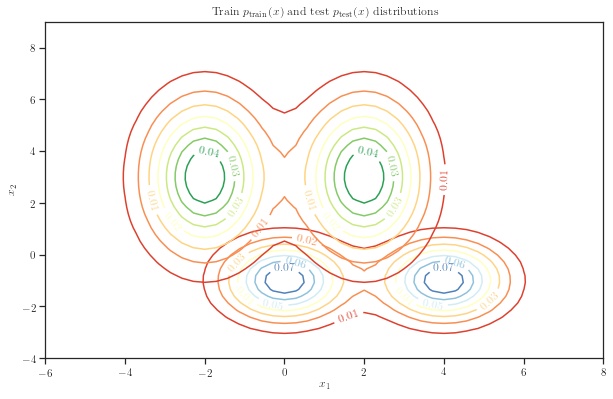

In [9]:
fig, ax = plt.subplots()

ax.set_title(r"Train $p_{\mathrm{train}}(x)$ and test $p_{\mathrm{test}}(x)$ distributions")

contours_train = ax.contour(x1, x2, pair.p.prob(X_q), cmap="RdYlBu")
contours_test = ax.contour(x1, x2, pair.q.prob(X_q), cmap="RdYlGn")

ax.clabel(contours_train, fmt='%.2f')
ax.clabel(contours_test, fmt='%.2f')

ax.set_xlabel(r'$x_1$')
ax.set_ylabel(r'$x_2$')

plt.show()

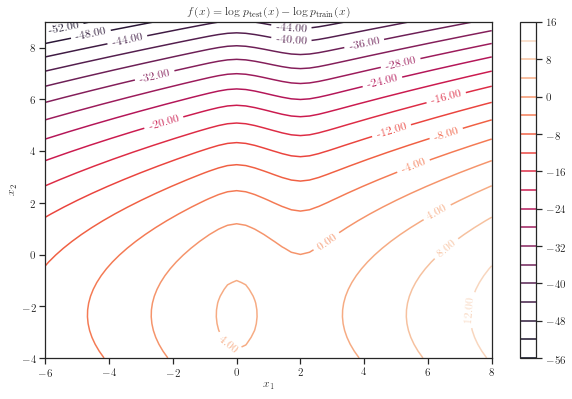

In [10]:
fig, ax = plt.subplots()

ax.set_title(r"$f(x) = \log p_{\mathrm{test}}(x) - \log p_{\mathrm{train}}(x)$")

contours = ax.contour(x1, x2, pair.logit(X_q), levels=20)

fig.colorbar(contours, ax=ax)
ax.clabel(contours, fmt='%.2f')

ax.set_xlabel(r'$x_1$')
ax.set_ylabel(r'$x_2$')

plt.show()

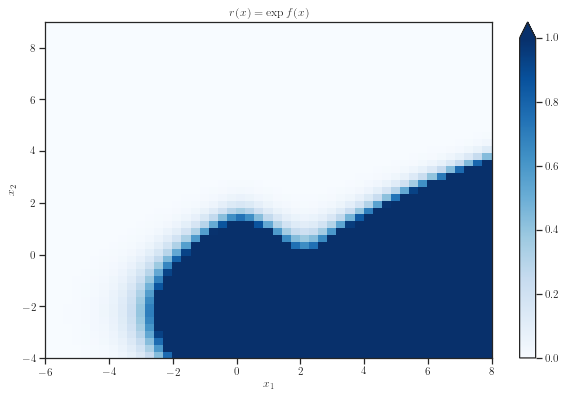

In [11]:
fig, ax = plt.subplots()

ax.set_title(r"$r(x) = \exp f(x)$")

contours = ax.pcolor(x1, x2, pair.density_ratio(X_q), vmax=1, cmap="Blues")

fig.colorbar(contours, extend="max", ax=ax)

ax.set_xlabel(r'$x_1$')
ax.set_ylabel(r'$x_2$')

plt.show()

In [12]:
X_test, X_train = pair.make_dataset(num_train + num_test, seed=seed)
X_train = X_train.squeeze()
X_test = X_test.squeeze()

In [13]:
X, y = make_classification_dataset(X_test, X_train)

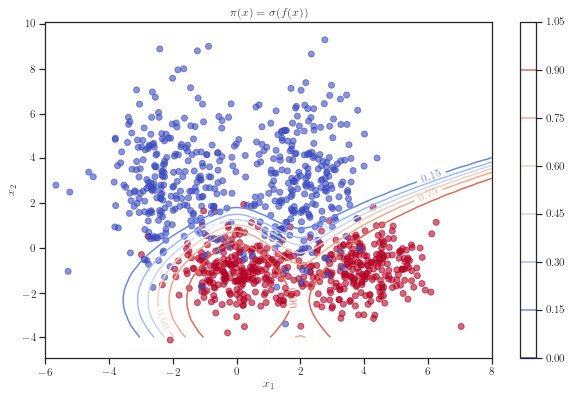

In [14]:
fig, ax = plt.subplots()

ax.set_title(r"$\pi(x) = \sigma(f(x))$")

contours = ax.contour(x1, x2, pair.optimal_score(X_q), cmap="coolwarm")

fig.colorbar(contours, ax=ax)
ax.clabel(contours, fmt='%.2f')

# ax.scatter(*X_train.T, c="tab:blue", alpha=0.7, label="train")
# ax.scatter(*X_test.T, c="tab:red", marker='x', alpha=0.7, label="test")

ax.scatter(*X.T, c=y, alpha=0.6, cmap="coolwarm")
# ax.set_yticks([0, 1])
# ax.set_yticklabels([r"$x_q \sim q(x)$", r"$x_p \sim p(x)$"])
# ax.set_xlabel('$x$')

ax.set_xlabel(r'$x_1$')
ax.set_ylabel(r'$x_2$')

# ax.legend()

plt.show()

In [30]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.regularizers import l1_l2

In [47]:
def binary_crossentropy_from_logits(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred, from_logits=True)


def build_model(output_dim, num_layers=1, num_units=8, activation="tanh",
                seed=None, *args, **kwargs):
    """
    Instantiate a multi-layer perceptron with rectangular-shaped hidden
    layers.
    """
    model = Sequential()

    for l in range(num_layers):

        model.add(Dense(num_units,
                        activation=activation,
                        kernel_initializer=glorot_uniform(seed=seed),
                        *args, **kwargs))

    model.add(Dense(output_dim, kernel_initializer=glorot_uniform(seed=seed)))

    return model

In [63]:
# Model specification
model = build_model(output_dim=1, num_layers=2,
                    num_units=16, activation="relu",
                    seed=seed)
model.compile(loss=binary_crossentropy_from_logits, optimizer=optimizer,
              metrics=["accuracy"])
hist = model.fit(X, y, batch_size=64, epochs=1000, shuffle=True)

Train on 1000 samples
Epoch 1/1000
1000/1000 [==============================] - 0s 283us/sample - loss: 0.3747 - accuracy: 0.7100
Epoch 2/1000
1000/1000 [==============================] - 0s 47us/sample - loss: 0.2147 - accuracy: 0.9190
Epoch 3/1000
1000/1000 [==============================] - 0s 43us/sample - loss: 0.1904 - accuracy: 0.9300
Epoch 4/1000
1000/1000 [==============================] - 0s 38us/sample - loss: 0.1854 - accuracy: 0.9300
Epoch 5/1000
1000/1000 [==============================] - 0s 41us/sample - loss: 0.1829 - accuracy: 0.9290
Epoch 6/1000
1000/1000 [==============================] - 0s 40us/sample - loss: 0.1812 - accuracy: 0.9280
Epoch 7/1000
1000/1000 [==============================] - 0s 39us/sample - loss: 0.1783 - accuracy: 0.9310
Epoch 8/1000
1000/1000 [==============================] - 0s 43us/sample - loss: 0.1776 - accuracy: 0.9320
Epoch 9/1000
1000/1000 [==============================] - 0s 39us/sample - loss: 0.1761 - accuracy: 0.9350
Epoch 10/1000


1000/1000 [==============================] - 0s 35us/sample - loss: 0.1504 - accuracy: 0.9440
Epoch 77/1000
1000/1000 [==============================] - 0s 40us/sample - loss: 0.1494 - accuracy: 0.9450
Epoch 78/1000
1000/1000 [==============================] - 0s 36us/sample - loss: 0.1497 - accuracy: 0.9470
Epoch 79/1000
1000/1000 [==============================] - 0s 32us/sample - loss: 0.1492 - accuracy: 0.9470
Epoch 80/1000
1000/1000 [==============================] - 0s 38us/sample - loss: 0.1492 - accuracy: 0.9470
Epoch 81/1000
1000/1000 [==============================] - 0s 40us/sample - loss: 0.1499 - accuracy: 0.9440
Epoch 82/1000
1000/1000 [==============================] - 0s 36us/sample - loss: 0.1484 - accuracy: 0.9450
Epoch 83/1000
1000/1000 [==============================] - 0s 32us/sample - loss: 0.1486 - accuracy: 0.9470
Epoch 84/1000
1000/1000 [==============================] - 0s 31us/sample - loss: 0.1484 - accuracy: 0.9480
Epoch 85/1000
1000/1000 [=================

1000/1000 [==============================] - 0s 53us/sample - loss: 0.1412 - accuracy: 0.9490
Epoch 152/1000
1000/1000 [==============================] - 0s 33us/sample - loss: 0.1415 - accuracy: 0.9490
Epoch 153/1000
1000/1000 [==============================] - 0s 31us/sample - loss: 0.1411 - accuracy: 0.9500
Epoch 154/1000
1000/1000 [==============================] - 0s 35us/sample - loss: 0.1415 - accuracy: 0.9480
Epoch 155/1000
1000/1000 [==============================] - 0s 36us/sample - loss: 0.1412 - accuracy: 0.9500
Epoch 156/1000
1000/1000 [==============================] - 0s 35us/sample - loss: 0.1415 - accuracy: 0.9480
Epoch 157/1000
1000/1000 [==============================] - 0s 33us/sample - loss: 0.1410 - accuracy: 0.9500
Epoch 158/1000
1000/1000 [==============================] - 0s 33us/sample - loss: 0.1411 - accuracy: 0.9500
Epoch 159/1000
1000/1000 [==============================] - 0s 44us/sample - loss: 0.1409 - accuracy: 0.9480
Epoch 160/1000
1000/1000 [========

1000/1000 [==============================] - 0s 46us/sample - loss: 0.1375 - accuracy: 0.9500
Epoch 227/1000
1000/1000 [==============================] - 0s 46us/sample - loss: 0.1379 - accuracy: 0.9510
Epoch 228/1000
1000/1000 [==============================] - 0s 38us/sample - loss: 0.1377 - accuracy: 0.9490
Epoch 229/1000
1000/1000 [==============================] - 0s 37us/sample - loss: 0.1377 - accuracy: 0.9520
Epoch 230/1000
1000/1000 [==============================] - 0s 31us/sample - loss: 0.1379 - accuracy: 0.9510
Epoch 231/1000
1000/1000 [==============================] - 0s 32us/sample - loss: 0.1372 - accuracy: 0.9510
Epoch 232/1000
1000/1000 [==============================] - 0s 33us/sample - loss: 0.1380 - accuracy: 0.9490
Epoch 233/1000
1000/1000 [==============================] - 0s 30us/sample - loss: 0.1378 - accuracy: 0.9500
Epoch 234/1000
1000/1000 [==============================] - 0s 63us/sample - loss: 0.1374 - accuracy: 0.9500
Epoch 235/1000
1000/1000 [========

1000/1000 [==============================] - 0s 65us/sample - loss: 0.1352 - accuracy: 0.9530
Epoch 302/1000
1000/1000 [==============================] - 0s 45us/sample - loss: 0.1355 - accuracy: 0.9520
Epoch 303/1000
1000/1000 [==============================] - 0s 37us/sample - loss: 0.1351 - accuracy: 0.9520
Epoch 304/1000
1000/1000 [==============================] - 0s 45us/sample - loss: 0.1351 - accuracy: 0.9520
Epoch 305/1000
1000/1000 [==============================] - 0s 45us/sample - loss: 0.1354 - accuracy: 0.9510
Epoch 306/1000
1000/1000 [==============================] - 0s 39us/sample - loss: 0.1346 - accuracy: 0.9530
Epoch 307/1000
1000/1000 [==============================] - 0s 39us/sample - loss: 0.1350 - accuracy: 0.9510
Epoch 308/1000
1000/1000 [==============================] - 0s 42us/sample - loss: 0.1350 - accuracy: 0.9530
Epoch 309/1000
1000/1000 [==============================] - 0s 40us/sample - loss: 0.1349 - accuracy: 0.9520
Epoch 310/1000
1000/1000 [========

1000/1000 [==============================] - 0s 46us/sample - loss: 0.1331 - accuracy: 0.9520
Epoch 376/1000
1000/1000 [==============================] - 0s 39us/sample - loss: 0.1327 - accuracy: 0.9520
Epoch 377/1000
1000/1000 [==============================] - 0s 40us/sample - loss: 0.1329 - accuracy: 0.9530
Epoch 378/1000
1000/1000 [==============================] - 0s 44us/sample - loss: 0.1333 - accuracy: 0.9530
Epoch 379/1000
1000/1000 [==============================] - 0s 45us/sample - loss: 0.1331 - accuracy: 0.9500
Epoch 380/1000
1000/1000 [==============================] - 0s 40us/sample - loss: 0.1329 - accuracy: 0.9530
Epoch 381/1000
1000/1000 [==============================] - 0s 36us/sample - loss: 0.1326 - accuracy: 0.9540
Epoch 382/1000
1000/1000 [==============================] - 0s 40us/sample - loss: 0.1328 - accuracy: 0.9520
Epoch 383/1000
1000/1000 [==============================] - 0s 42us/sample - loss: 0.1324 - accuracy: 0.9530
Epoch 384/1000
1000/1000 [========

1000/1000 [==============================] - 0s 38us/sample - loss: 0.1312 - accuracy: 0.9550
Epoch 451/1000
1000/1000 [==============================] - 0s 43us/sample - loss: 0.1314 - accuracy: 0.9560
Epoch 452/1000
1000/1000 [==============================] - 0s 37us/sample - loss: 0.1318 - accuracy: 0.9500
Epoch 453/1000
1000/1000 [==============================] - 0s 42us/sample - loss: 0.1308 - accuracy: 0.9520
Epoch 454/1000
1000/1000 [==============================] - 0s 39us/sample - loss: 0.1313 - accuracy: 0.9540
Epoch 455/1000
1000/1000 [==============================] - 0s 37us/sample - loss: 0.1309 - accuracy: 0.9550
Epoch 456/1000
1000/1000 [==============================] - 0s 43us/sample - loss: 0.1312 - accuracy: 0.9510
Epoch 457/1000
1000/1000 [==============================] - 0s 52us/sample - loss: 0.1305 - accuracy: 0.9490
Epoch 458/1000
1000/1000 [==============================] - 0s 49us/sample - loss: 0.1311 - accuracy: 0.9540
Epoch 459/1000
1000/1000 [========

1000/1000 [==============================] - 0s 39us/sample - loss: 0.1298 - accuracy: 0.9540
Epoch 526/1000
1000/1000 [==============================] - 0s 38us/sample - loss: 0.1305 - accuracy: 0.9500
Epoch 527/1000
1000/1000 [==============================] - 0s 38us/sample - loss: 0.1295 - accuracy: 0.9530
Epoch 528/1000
1000/1000 [==============================] - 0s 37us/sample - loss: 0.1293 - accuracy: 0.9530
Epoch 529/1000
1000/1000 [==============================] - 0s 48us/sample - loss: 0.1299 - accuracy: 0.9530
Epoch 530/1000
1000/1000 [==============================] - 0s 44us/sample - loss: 0.1305 - accuracy: 0.9520
Epoch 531/1000
1000/1000 [==============================] - 0s 67us/sample - loss: 0.1297 - accuracy: 0.9540
Epoch 532/1000
1000/1000 [==============================] - 0s 58us/sample - loss: 0.1300 - accuracy: 0.9530
Epoch 533/1000
1000/1000 [==============================] - 0s 61us/sample - loss: 0.1295 - accuracy: 0.9540
Epoch 534/1000
1000/1000 [========

1000/1000 [==============================] - 0s 54us/sample - loss: 0.1283 - accuracy: 0.9550
Epoch 601/1000
1000/1000 [==============================] - 0s 43us/sample - loss: 0.1287 - accuracy: 0.9550
Epoch 602/1000
1000/1000 [==============================] - 0s 42us/sample - loss: 0.1279 - accuracy: 0.9540
Epoch 603/1000
1000/1000 [==============================] - 0s 49us/sample - loss: 0.1284 - accuracy: 0.9520
Epoch 604/1000
1000/1000 [==============================] - 0s 56us/sample - loss: 0.1280 - accuracy: 0.9550
Epoch 605/1000
1000/1000 [==============================] - 0s 46us/sample - loss: 0.1286 - accuracy: 0.9540
Epoch 606/1000
1000/1000 [==============================] - 0s 40us/sample - loss: 0.1278 - accuracy: 0.9570
Epoch 607/1000
1000/1000 [==============================] - 0s 50us/sample - loss: 0.1282 - accuracy: 0.9530
Epoch 608/1000
1000/1000 [==============================] - 0s 50us/sample - loss: 0.1278 - accuracy: 0.9530
Epoch 609/1000
1000/1000 [========

1000/1000 [==============================] - 0s 42us/sample - loss: 0.1274 - accuracy: 0.9530
Epoch 676/1000
1000/1000 [==============================] - 0s 48us/sample - loss: 0.1270 - accuracy: 0.9540
Epoch 677/1000
1000/1000 [==============================] - 0s 36us/sample - loss: 0.1272 - accuracy: 0.9540
Epoch 678/1000
1000/1000 [==============================] - 0s 39us/sample - loss: 0.1268 - accuracy: 0.9550
Epoch 679/1000
1000/1000 [==============================] - 0s 51us/sample - loss: 0.1274 - accuracy: 0.9500
Epoch 680/1000
1000/1000 [==============================] - 0s 40us/sample - loss: 0.1269 - accuracy: 0.9560
Epoch 681/1000
1000/1000 [==============================] - 0s 46us/sample - loss: 0.1270 - accuracy: 0.9540
Epoch 682/1000
1000/1000 [==============================] - 0s 40us/sample - loss: 0.1284 - accuracy: 0.9550
Epoch 683/1000
1000/1000 [==============================] - 0s 49us/sample - loss: 0.1265 - accuracy: 0.9540
Epoch 684/1000
1000/1000 [========

1000/1000 [==============================] - 0s 45us/sample - loss: 0.1262 - accuracy: 0.9550
Epoch 751/1000
1000/1000 [==============================] - 0s 41us/sample - loss: 0.1265 - accuracy: 0.9550
Epoch 752/1000
1000/1000 [==============================] - 0s 50us/sample - loss: 0.1267 - accuracy: 0.9550
Epoch 753/1000
1000/1000 [==============================] - 0s 37us/sample - loss: 0.1257 - accuracy: 0.9540
Epoch 754/1000
1000/1000 [==============================] - 0s 42us/sample - loss: 0.1264 - accuracy: 0.9550
Epoch 755/1000
1000/1000 [==============================] - 0s 41us/sample - loss: 0.1276 - accuracy: 0.9520
Epoch 756/1000
1000/1000 [==============================] - 0s 42us/sample - loss: 0.1258 - accuracy: 0.9540
Epoch 757/1000
1000/1000 [==============================] - 0s 40us/sample - loss: 0.1265 - accuracy: 0.9540
Epoch 758/1000
1000/1000 [==============================] - 0s 43us/sample - loss: 0.1261 - accuracy: 0.9550
Epoch 759/1000
1000/1000 [========

1000/1000 [==============================] - 0s 43us/sample - loss: 0.1255 - accuracy: 0.9540
Epoch 826/1000
1000/1000 [==============================] - 0s 41us/sample - loss: 0.1255 - accuracy: 0.9520
Epoch 827/1000
1000/1000 [==============================] - 0s 44us/sample - loss: 0.1249 - accuracy: 0.9530
Epoch 828/1000
1000/1000 [==============================] - 0s 44us/sample - loss: 0.1255 - accuracy: 0.9540
Epoch 829/1000
1000/1000 [==============================] - 0s 46us/sample - loss: 0.1246 - accuracy: 0.9560
Epoch 830/1000
1000/1000 [==============================] - 0s 58us/sample - loss: 0.1251 - accuracy: 0.9530
Epoch 831/1000
1000/1000 [==============================] - 0s 53us/sample - loss: 0.1258 - accuracy: 0.9540
Epoch 832/1000
1000/1000 [==============================] - 0s 45us/sample - loss: 0.1259 - accuracy: 0.9500
Epoch 833/1000
1000/1000 [==============================] - 0s 38us/sample - loss: 0.1246 - accuracy: 0.9520
Epoch 834/1000
1000/1000 [========

1000/1000 [==============================] - 0s 40us/sample - loss: 0.1244 - accuracy: 0.9540
Epoch 901/1000
1000/1000 [==============================] - 0s 45us/sample - loss: 0.1241 - accuracy: 0.9540
Epoch 902/1000
1000/1000 [==============================] - 0s 46us/sample - loss: 0.1245 - accuracy: 0.9520
Epoch 903/1000
1000/1000 [==============================] - 0s 31us/sample - loss: 0.1251 - accuracy: 0.9540
Epoch 904/1000
1000/1000 [==============================] - 0s 42us/sample - loss: 0.1250 - accuracy: 0.9540
Epoch 905/1000
1000/1000 [==============================] - 0s 39us/sample - loss: 0.1247 - accuracy: 0.9520
Epoch 906/1000
1000/1000 [==============================] - 0s 42us/sample - loss: 0.1243 - accuracy: 0.9540
Epoch 907/1000
1000/1000 [==============================] - 0s 38us/sample - loss: 0.1242 - accuracy: 0.9550
Epoch 908/1000
1000/1000 [==============================] - 0s 43us/sample - loss: 0.1246 - accuracy: 0.9530
Epoch 909/1000
1000/1000 [========

1000/1000 [==============================] - 0s 47us/sample - loss: 0.1237 - accuracy: 0.9540
Epoch 976/1000
1000/1000 [==============================] - 0s 49us/sample - loss: 0.1238 - accuracy: 0.9540
Epoch 977/1000
1000/1000 [==============================] - 0s 38us/sample - loss: 0.1234 - accuracy: 0.9540
Epoch 978/1000
1000/1000 [==============================] - 0s 40us/sample - loss: 0.1258 - accuracy: 0.9550
Epoch 979/1000
1000/1000 [==============================] - 0s 42us/sample - loss: 0.1235 - accuracy: 0.9540
Epoch 980/1000
1000/1000 [==============================] - 0s 47us/sample - loss: 0.1239 - accuracy: 0.9520
Epoch 981/1000
1000/1000 [==============================] - 0s 42us/sample - loss: 0.1243 - accuracy: 0.9520
Epoch 982/1000
1000/1000 [==============================] - 0s 44us/sample - loss: 0.1236 - accuracy: 0.9530
Epoch 983/1000
1000/1000 [==============================] - 0s 37us/sample - loss: 0.1233 - accuracy: 0.9540
Epoch 984/1000
1000/1000 [========

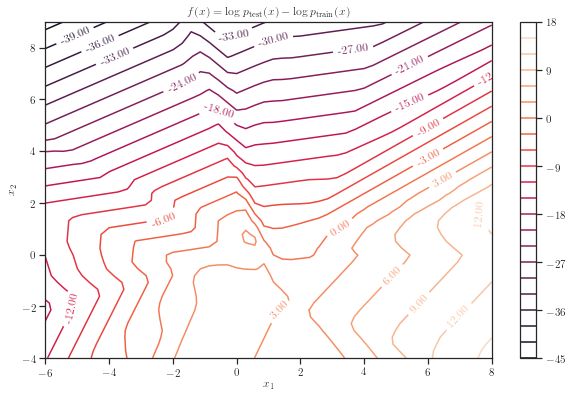

In [64]:
fig, ax = plt.subplots()

ax.set_title(r"$f(x) = \log p_{\mathrm{test}}(x) - \log p_{\mathrm{train}}(x)$")

contours = ax.contour(x1, x2, model.predict(X_q).squeeze(), levels=20)

fig.colorbar(contours, ax=ax)
ax.clabel(contours, fmt='%.2f')

ax.set_xlabel(r'$x_1$')
ax.set_ylabel(r'$x_2$')

plt.show()

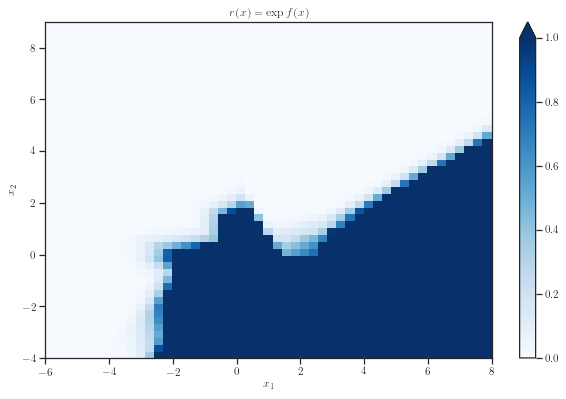

In [65]:
fig, ax = plt.subplots()

ax.set_title(r"$r(x) = \exp f(x)$")

contours = ax.pcolor(x1, x2, np.exp(model.predict(X_q)).squeeze(), vmax=1, cmap="Blues")

fig.colorbar(contours, extend="max", ax=ax)

ax.set_xlabel(r'$x_1$')
ax.set_ylabel(r'$x_2$')

plt.show()

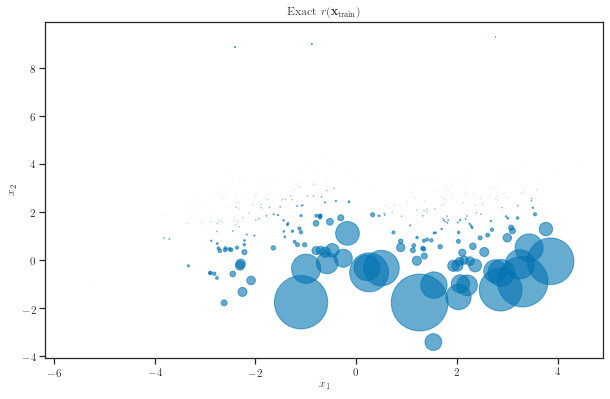

In [66]:
fig, ax = plt.subplots()

ax.set_title(r"Exact $r(\mathbf{x}_{\mathrm{train}})$")

ax.scatter(*X_train.T, s=1e2*np.exp(model.predict(X_train)), alpha=0.6)

ax.set_xlabel(r'$x_1$')
ax.set_ylabel(r'$x_2$')

plt.show()

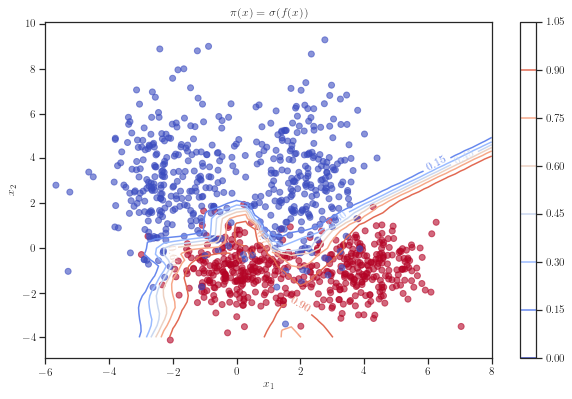

In [67]:
fig, ax = plt.subplots()

ax.set_title(r"$\pi(x) = \sigma(f(x))$")

contours = ax.contour(x1, x2, tf.sigmoid(model.predict(X_q)).numpy().squeeze(), cmap="coolwarm")

fig.colorbar(contours, ax=ax)
ax.clabel(contours, fmt='%.2f')

# ax.scatter(*X_train.T, c="tab:blue", alpha=0.7, label="train")
# ax.scatter(*X_test.T, c="tab:red", marker='x', alpha=0.7, label="test")

ax.scatter(*X.T, c=y, alpha=0.6, cmap="coolwarm")
# ax.set_yticks([0, 1])
# ax.set_yticklabels([r"$x_q \sim q(x)$", r"$x_p \sim p(x)$"])
# ax.set_xlabel('$x$')

ax.set_xlabel(r'$x_1$')
ax.set_ylabel(r'$x_2$')

# ax.legend()

plt.show()

Encapsulate Variational Gaussian Process (particular variable initialization)
in a Keras / TensorFlow Probability Mixin Layer.
Clean and simple if we restrict to single-output (`event_shape = ()`) and
`feature_ndim = 1` (i.e. inputs are simply vectors rather than matrices or
tensors).



In [15]:
class VariationalGaussianProcess1D(tfp.layers.DistributionLambda):

    def __init__(self, kernel_wrapper, num_inducing_points,
                 inducing_index_points_initializer, mean_fn=None, jitter=1e-6,
                 convert_to_tensor_fn=tfd.Distribution.sample, **kwargs):

        def make_distribution(x):

            return VariationalGaussianProcess1D.new(
                x, kernel_wrapper=self.kernel_wrapper,
                inducing_index_points=self.inducing_index_points,
                variational_inducing_observations_loc=(
                    self.variational_inducing_observations_loc),
                variational_inducing_observations_scale=(
                    self.variational_inducing_observations_scale),
                mean_fn=self.mean_fn,
                observation_noise_variance=tf.exp(
                    self.log_observation_noise_variance),
                jitter=self.jitter)

        super(VariationalGaussianProcess1D, self).__init__(
            make_distribution_fn=make_distribution,
            convert_to_tensor_fn=convert_to_tensor_fn,
            dtype=kernel_wrapper.dtype)

        self.kernel_wrapper = kernel_wrapper
        self.inducing_index_points_initializer = inducing_index_points_initializer
        self.num_inducing_points = num_inducing_points
        self.mean_fn = mean_fn
        self.jitter = jitter

        self._dtype = self.kernel_wrapper.dtype

    def build(self, input_shape):

        input_dim = input_shape[-1]

        # TODO: Fix initialization!
        self.inducing_index_points = self.add_weight(
            name="inducing_index_points",
            shape=(self.num_inducing_points, input_dim),
            initializer=self.inducing_index_points_initializer,
            dtype=self.dtype)

        self.variational_inducing_observations_loc = self.add_weight(
            name="variational_inducing_observations_loc",
            shape=(self.num_inducing_points,),
            initializer="zeros", dtype=self.dtype)

        self.variational_inducing_observations_scale = self.add_weight(
            name="variational_inducing_observations_scale",
            shape=(self.num_inducing_points, self.num_inducing_points),
            initializer=Identity(gain=1.0), dtype=self.dtype)

        self.log_observation_noise_variance = self.add_weight(
            name="log_observation_noise_variance",
            initializer=Constant(-5.0), dtype=self.dtype)

    @staticmethod
    def new(x, kernel_wrapper, inducing_index_points, mean_fn,
            variational_inducing_observations_loc,
            variational_inducing_observations_scale,
            observation_noise_variance, jitter, name=None):

        # ind = tfd.Independent(base, reinterpreted_batch_ndims=1)
        # bijector = tfp.bijectors.Transpose(rightmost_transposed_ndims=2)
        # d = tfd.TransformedDistribution(ind, bijector=bijector)

        return tfd.VariationalGaussianProcess(
            kernel=kernel_wrapper.kernel, index_points=x,
            inducing_index_points=inducing_index_points,
            variational_inducing_observations_loc=(
                variational_inducing_observations_loc),
            variational_inducing_observations_scale=(
                variational_inducing_observations_scale),
            mean_fn=mean_fn,
            observation_noise_variance=observation_noise_variance,
            jitter=jitter)

Kernel wrapper layer



In [16]:
class KernelWrapper(Layer):

    # TODO: Support automatic relevance determination
    def __init__(self, input_dim=1, kernel_cls=kernels.ExponentiatedQuadratic,
                 dtype=None, **kwargs):

        super(KernelWrapper, self).__init__(dtype=dtype, **kwargs)

        self.kernel_cls = kernel_cls

        self.log_amplitude = self.add_weight(
            name="log_amplitude",
            initializer="zeros", dtype=dtype)

        self.log_length_scale = self.add_weight(
            name="log_length_scale",
            initializer="zeros", dtype=dtype)
        
        self.log_scale_diag = self.add_weight(
            name="log_scale_diag", shape=(input_dim,),
            initializer="zeros", dtype=dtype)

    def call(self, x):
        # Never called -- this is just a layer so it can hold variables
        # in a way Keras understands.
        return x

    @property
    def kernel(self):
        base_kernel = self.kernel_cls(amplitude=tf.exp(self.log_amplitude),
                                      length_scale=tf.exp(self.log_length_scale))
        return kernels.FeatureScaled(base_kernel, scale_diag=tf.exp(self.log_scale_diag))

Bernoulli likelihood for binary classification.



In [17]:
def make_binary_classification_likelihood(f):

    return tfd.Independent(tfd.Bernoulli(logits=f),
                           reinterpreted_batch_ndims=1)

In [18]:
def log_likelihood(y, f):

    likelihood = make_binary_classification_likelihood(f)
    return likelihood.log_prob(y)

Helper Model factory method.



In [19]:
def build_model(input_dim, jitter=1e-6):

    return tf.keras.Sequential([
        InputLayer(input_shape=(input_dim,)),
        VariationalGaussianProcess1D(
            kernel_wrapper=KernelWrapper(input_dim=2,
                                         kernel_cls=kernel_cls,
                                         dtype=tf.float64),
            num_inducing_points=num_inducing_points,
            inducing_index_points_initializer=KMeans(X),
            jitter=jitter)
    ])

In [20]:
model = build_model(input_dim=num_features, jitter=jitter)
optimizer = tf.keras.optimizers.Adam()

Instructions for updating:
Do not pass `graph_parents`.  They will  no longer be used.


/usr/local/lib/python3.6/dist-packages/tensorflow_probability/python/distributions/gaussian_process.py:305: UserWarning: Unable to detect statically whether the number of index_points is 1. As a result, defaulting to treating the marginal GP at `index_points` as a multivariate Gaussian. This makes some methods, like `cdf` unavailable.
  'Unable to detect statically whether the number of index_points is '


In [21]:
@tf.function
def nelbo(X_batch, y_batch):

    qf = model(X_batch)

    ell = qf.surrogate_posterior_expected_log_likelihood(
        observations=y_batch,
        log_likelihood_fn=log_likelihood,
        quadrature_size=quadrature_size)

    kl = qf.surrogate_posterior_kl_divergence_prior()
    kl_weight = get_kl_weight(num_train, batch_size)

    return - ell + kl_weight * kl

In [22]:
@tf.function
def train_step(X_batch, y_batch):

    with tf.GradientTape() as tape:
        loss = nelbo(X_batch, y_batch)
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    return loss

In [23]:
dataset = tf.data.Dataset.from_tensor_slices((X, y)) \
                         .shuffle(seed=seed, buffer_size=shuffle_buffer_size) \
                         .batch(batch_size, drop_remainder=True)

In [24]:
keys = ["inducing_index_points",
        "variational_inducing_observations_loc",
        "variational_inducing_observations_scale",
        "log_observation_noise_variance",
        "log_amplitude", "log_length_scale"]

In [25]:
num_epochs = 500

In [26]:
history = defaultdict(list)

for epoch in range(num_epochs):

    for step, (X_batch, y_batch) in enumerate(dataset):

        loss = train_step(X_batch, y_batch)

    print("epoch={epoch:04d}, loss={loss:.4f}"
          .format(epoch=epoch, loss=loss.numpy()))

    history["nelbo"].append(loss.numpy())

    for key, tensor in zip(keys, model.get_weights()):

        history[key].append(tensor)

epoch=0000, loss=52.0156
epoch=0001, loss=51.3480
epoch=0002, loss=50.6525
epoch=0003, loss=50.0678
epoch=0004, loss=49.9008
epoch=0005, loss=49.1063
epoch=0006, loss=48.5713
epoch=0007, loss=48.0995
epoch=0008, loss=47.8012
epoch=0009, loss=47.2528
epoch=0010, loss=46.8333
epoch=0011, loss=46.5058
epoch=0012, loss=46.4622
epoch=0013, loss=45.7931
epoch=0014, loss=45.4212
epoch=0015, loss=45.4784
epoch=0016, loss=44.4731
epoch=0017, loss=44.3933
epoch=0018, loss=43.4201
epoch=0019, loss=42.9468
epoch=0020, loss=42.8970
epoch=0021, loss=43.3469
epoch=0022, loss=43.5078
epoch=0023, loss=42.1839
epoch=0024, loss=42.1327
epoch=0025, loss=41.3660
epoch=0026, loss=40.8173
epoch=0027, loss=39.4739
epoch=0028, loss=40.3995
epoch=0029, loss=39.6607
epoch=0030, loss=38.7249
epoch=0031, loss=39.4007
epoch=0032, loss=39.4445
epoch=0033, loss=38.3729
epoch=0034, loss=38.4419
epoch=0035, loss=38.0760
epoch=0036, loss=37.6781
epoch=0037, loss=37.7910
epoch=0038, loss=39.4157
epoch=0039, loss=36.3490


epoch=0331, loss=8.9046
epoch=0332, loss=13.1395
epoch=0333, loss=15.3607
epoch=0334, loss=13.8902
epoch=0335, loss=17.1133
epoch=0336, loss=12.6669
epoch=0337, loss=11.0656
epoch=0338, loss=11.7771
epoch=0339, loss=13.4007
epoch=0340, loss=13.4928
epoch=0341, loss=10.3837
epoch=0342, loss=11.3933
epoch=0343, loss=9.9702
epoch=0344, loss=18.2700
epoch=0345, loss=17.2355
epoch=0346, loss=10.5694
epoch=0347, loss=17.4627
epoch=0348, loss=16.1603
epoch=0349, loss=11.4800
epoch=0350, loss=15.2009
epoch=0351, loss=14.6638
epoch=0352, loss=11.2635
epoch=0353, loss=11.2795
epoch=0354, loss=11.5070
epoch=0355, loss=15.9414
epoch=0356, loss=12.6844
epoch=0357, loss=12.5623
epoch=0358, loss=12.1699
epoch=0359, loss=15.5432
epoch=0360, loss=12.5044
epoch=0361, loss=11.6841
epoch=0362, loss=12.6520
epoch=0363, loss=17.6866
epoch=0364, loss=18.0470
epoch=0365, loss=15.3415
epoch=0366, loss=14.9940
epoch=0367, loss=17.7929
epoch=0368, loss=16.2285
epoch=0369, loss=8.7332
epoch=0370, loss=16.8839
epo

In [29]:
history_df = pd.DataFrame(history)
history_df.index.name = "epoch"
history_df.reset_index(inplace=True)

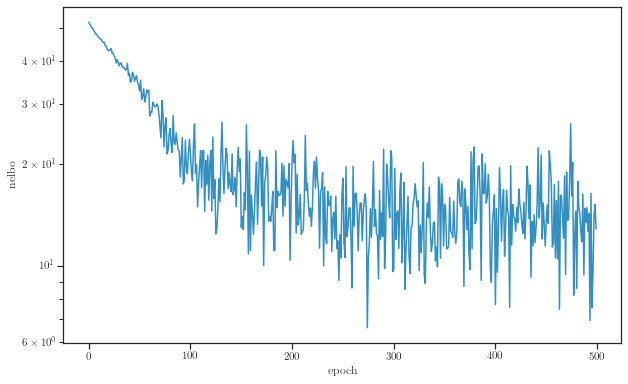

In [30]:
fig, ax = plt.subplots()

sns.lineplot(x="epoch", y="nelbo", data=history_df, alpha=0.8, ax=ax)
ax.set_yscale("log")

plt.show()

In [31]:
[inducing_index_points, variational_inducing_observations_loc, 
 variational_inducing_observations_scale, 
 log_observation_noise_variance, log_amplitude, 
 log_length_scale, log_scale_diag] = model.get_weights()

In [32]:
test_model = build_model(input_dim=num_features, jitter=2.0*jitter)
test_model.set_weights(model.get_weights())

/usr/local/lib/python3.6/dist-packages/tensorflow_probability/python/distributions/gaussian_process.py:305: UserWarning: Unable to detect statically whether the number of index_points is 1. As a result, defaulting to treating the marginal GP at `index_points` as a multivariate Gaussian. This makes some methods, like `cdf` unavailable.
  'Unable to detect statically whether the number of index_points is '


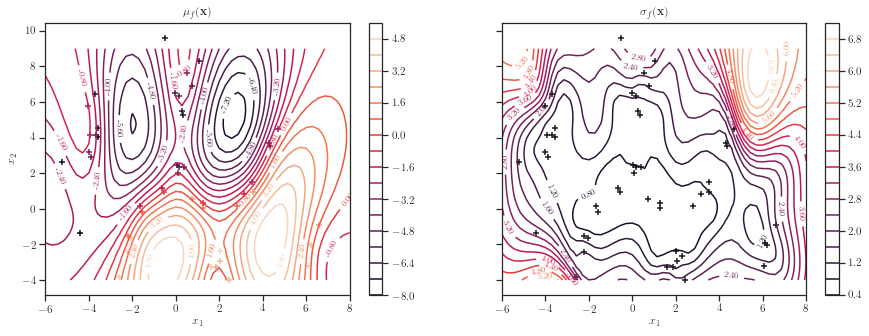

In [33]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15, 5), sharey=True)

ax1.set_title(r"$\mu_{f}(\mathbf{x})$")
ax2.set_title(r"$\sigma_{f}(\mathbf{x})$")

ax1.scatter(*inducing_index_points.T, marker='+', c=variational_inducing_observations_loc)
ax2.scatter(*inducing_index_points.T, marker='+', c='k')

contours_mean = ax1.contour(x1, x2, model(X_q).mean(), levels=20)
contours_stddev = ax2.contour(x1, x2, model(X_q).stddev(), levels=20)

fig.colorbar(contours_mean, ax=ax1)
fig.colorbar(contours_stddev, ax=ax2)

ax1.clabel(contours_mean, fontsize=8, fmt='%.2f')
ax2.clabel(contours_stddev, fontsize=8, fmt='%.2f')

ax1.set_xlabel(r'$x_1$')
ax1.set_ylabel(r'$x_2$')

ax2.set_xlabel(r'$x_1$')

plt.show()

In [69]:
def make_dre(X):

    return tfd.Independent(tfd.LogNormal(loc=model(X).mean(),
                                         scale=model(X).stddev()),
                           reinterpreted_batch_ndims=1)

In [70]:
dre = make_dre(X_q)

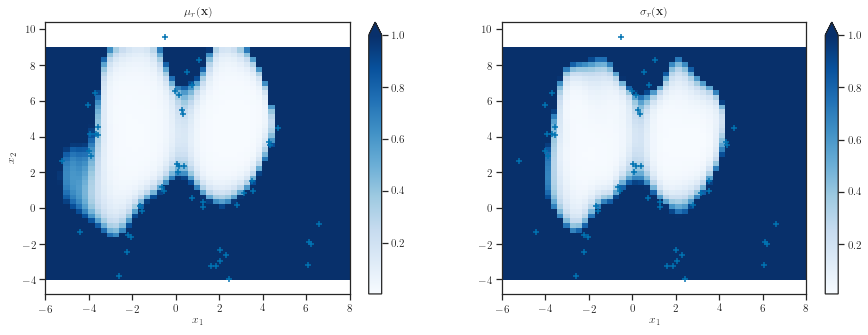

In [71]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15, 5))

ax1.set_title(r"$\mu_{r}(\mathbf{x})$")
ax2.set_title(r"$\sigma_{r}(\mathbf{x})$")

contours_mean = ax1.pcolor(x1, x2, dre.mean(), vmax=1, cmap="Blues")
contours_stddev = ax2.pcolor(x1, x2, dre.stddev(), vmax=1, cmap="Blues")

ax1.scatter(*inducing_index_points.T, marker='+')
ax2.scatter(*inducing_index_points.T, marker='+')

fig.colorbar(contours_mean, extend="max", ax=ax1)
fig.colorbar(contours_stddev, extend="max", ax=ax2)

ax1.set_xlabel(r'$x_1$')
ax1.set_ylabel(r'$x_2$')

ax2.set_xlabel(r'$x_1$')

plt.show()

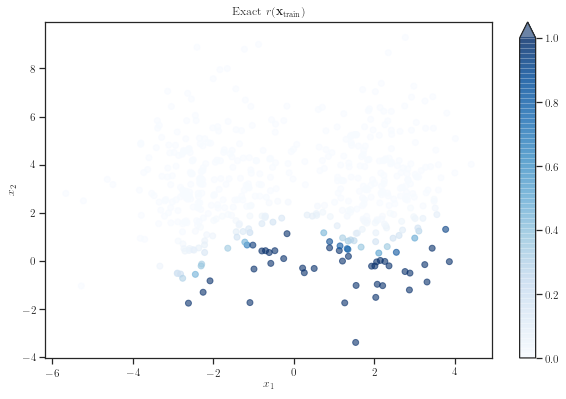

In [115]:
fig, ax = plt.subplots()

ax.set_title(r"Exact $r(\mathbf{x}_{\mathrm{train}})$")

cb = ax.scatter(*X_train.T, c=pair.density_ratio(X_train), alpha=0.6, vmax=1.0, cmap="Blues")
fig.colorbar(cb, extend="max", ax=ax)

ax.set_xlabel(r'$x_1$')
ax.set_ylabel(r'$x_2$')

plt.show()

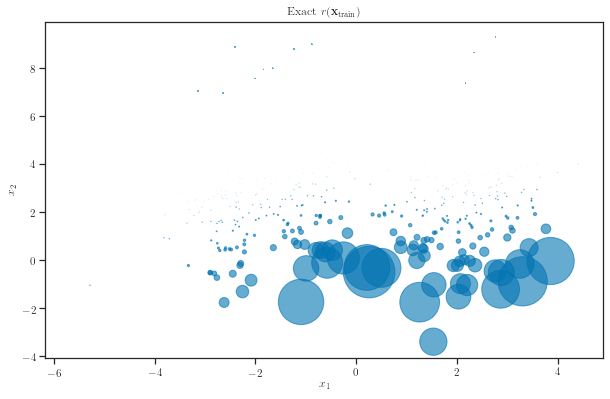

In [116]:
fig, ax = plt.subplots()

ax.set_title(r"Exact $r(\mathbf{x}_{\mathrm{train}})$")

ax.scatter(*X_train.T, s=1e2*pair.density_ratio(X_train), alpha=0.6)

ax.set_xlabel(r'$x_1$')
ax.set_ylabel(r'$x_2$')

plt.show()

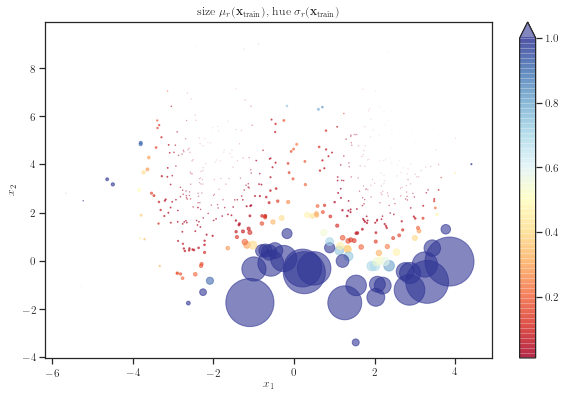

In [119]:
fig, ax = plt.subplots()

ax.set_title(r"size $\mu_{r}(\mathbf{x}_{\mathrm{train}})$, hue $\sigma_{r}(\mathbf{x}_{\mathrm{train}})$")

cb = ax.scatter(*X_train.T, s=1e2*make_dre(X_train).mode(), 
                c=make_dre(X_train).stddev(), vmax=1.0, alpha=0.6, cmap="RdYlBu")

fig.colorbar(cb, extend="max", ax=ax)

ax.set_xlabel(r'$x_1$')
ax.set_ylabel(r'$x_2$')

plt.show()

In [75]:
make_dre(X_train).mean().numpy().argmax()

141

In [56]:
m = tfd.LogNormal(loc=model(X_train[141:142]).mean(),
                  scale=model(X_train[141:142]).stddev())

In [57]:
m.stddev()

<tf.Tensor: shape=(), dtype=float64, numpy=145.49292654694338>

In [110]:
y = np.linspace(0, 150, 256)

In [111]:
m.sample(5).numpy().reshape(-1, 1)

array([[321.05537558],
       [ 40.87114913],
       [ 29.6173695 ],
       [126.12109023],
       [110.70057253]])

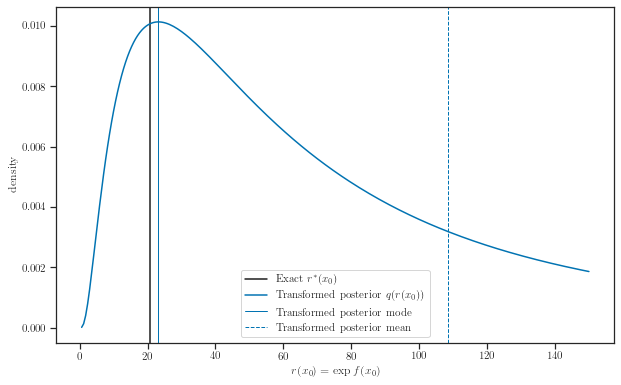

In [114]:
fig, ax = plt.subplots()

ax.axvline(pair.density_ratio(X_train[141:142]).numpy().squeeze(), c="k", label=r"Exact $r^*(x_0)$")

ax.plot(y, m.prob(y), label=r"Transformed posterior $q(r(x_0))$")

ax.axvline(m.mode().numpy().squeeze(), linewidth=1.0, label="Transformed posterior mode")
ax.axvline(m.mean().numpy().squeeze(), linestyle="--", linewidth=1.0, label="Transformed posterior mean")
# ax.axvline(m.quantile(0.25).numpy().squeeze())

ax.set_xlabel(r"$r(x_0) = \exp{f(x_0)}$")
ax.set_ylabel("density")

ax.legend()

plt.show()

In [ ]:
m.prob()

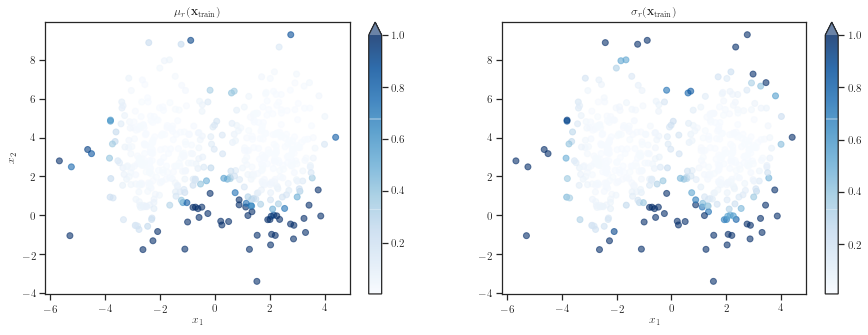

In [120]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15, 5))

ax1.set_title(r"$\mu_{r}(\mathbf{x}_{\mathrm{train}})$")
ax2.set_title(r"$\sigma_{r}(\mathbf{x}_{\mathrm{train}})$")

cb1 = ax1.scatter(*X_train.T, c=make_dre(X_train).mean(), alpha=0.6, vmax=1.0, cmap="Blues")
cb2 = ax2.scatter(*X_train.T, c=make_dre(X_train).stddev(), alpha=0.6, vmax=1.0, cmap="Blues")

fig.colorbar(cb1, extend="max", ax=ax1)
fig.colorbar(cb2, extend="max", ax=ax2)

ax1.set_xlabel(r'$x_1$')
ax1.set_ylabel(r'$x_2$')

ax2.set_xlabel(r'$x_1$')

plt.show()

In [121]:
class_posterior = lambda x1, x2: 0.5 * (1 + tf.tanh(x1 - tf.nn.relu(-x2)))

In [122]:
tau = 0.5

In [123]:
y_train = np.float64(class_posterior(*X_train.T) > tau)
y_test = np.float64(class_posterior(*X_test.T) > tau)

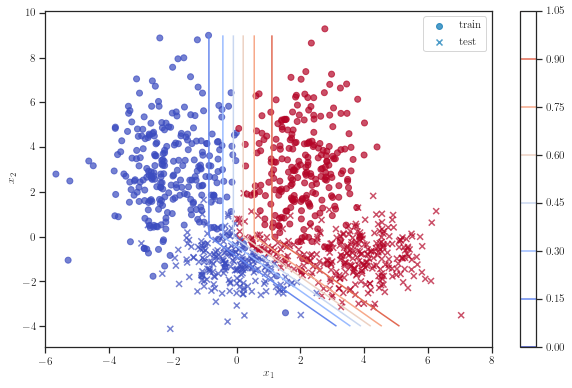

In [124]:
fig, ax = plt.subplots()

contours = ax.contour(x1, x2, class_posterior(x1, x2), cmap="coolwarm")

ax.scatter(*X_train.T, c=y_train, cmap="coolwarm", alpha=0.7, label="train")
ax.scatter(*X_test.T, c=y_test, marker='x', cmap="coolwarm", alpha=0.7, label="test")

fig.colorbar(contours, ax=ax)

ax.legend()

ax.set_xlabel(r'$x_1$')
ax.set_ylabel(r'$x_2$')

plt.show()

In [168]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC

In [215]:
# model = LogisticRegression(C=1.0, penalty="l2", solver="lbfgs",
#                            max_iter=500, random_state=seed)
# model.fit(X_train, y_train, sample_weight=pair.density_ratio(X_train).numpy())

model = LinearSVC(C=1.0, max_iter=5000, random_state=seed)
model.fit(X_train, y_train)

# model = SVC(kernel="poly", C=1.0, max_iter=10000, random_state=seed)
# model.fit(X_train, y_train)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=5000,
          multi_class='ovr', penalty='l2', random_state=8888, tol=0.0001,
          verbose=0)

In [216]:
model.score(X_test, y_test)

0.914

In [217]:
model.decision_function(X_q.reshape(-1, 2)).reshape(50, 50)

array([[-11.69956179, -11.22537067, -10.75117955, ...,  10.58742084,
         11.06161196,  11.53580308],
       [-11.64917799, -11.17498687, -10.70079575, ...,  10.63780464,
         11.11199575,  11.58618687],
       [-11.5987942 , -11.12460308, -10.65041196, ...,  10.68818843,
         11.16237955,  11.63657067],
       ...,
       [ -9.33152348,  -8.85733236,  -8.38314124, ...,  12.95545915,
         13.42965027,  13.90384139],
       [ -9.28113968,  -8.80694856,  -8.33275745, ...,  13.00584294,
         13.48003406,  13.95422518],
       [ -9.23075589,  -8.75656477,  -8.28237365, ...,  13.05622674,
         13.53041786,  14.00460898]])

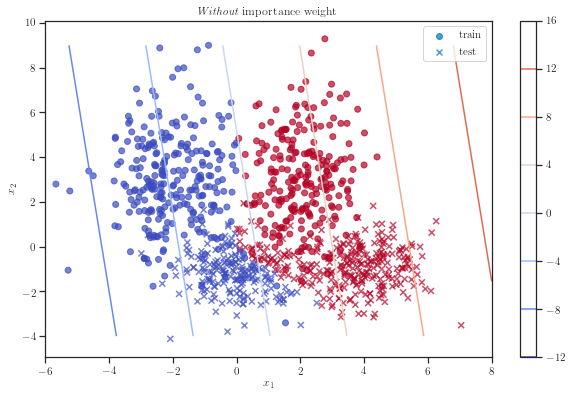

In [218]:
fig, ax = plt.subplots()

ax.set_title(r"\emph{Without} importance weight")

contours = ax.contour(x1, x2, model.decision_function(X_q.reshape(-1, 2)).reshape(50, 50), cmap="coolwarm")

ax.scatter(*X_train.T, c=y_train, cmap="coolwarm", alpha=0.7, label="train")
ax.scatter(*X_test.T, c=y_test, marker='x', cmap="coolwarm", alpha=0.7, label="test")

fig.colorbar(contours, ax=ax)

ax.legend()

ax.set_xlabel(r'$x_1$')
ax.set_ylabel(r'$x_2$')

plt.show()

In [125]:
def build_model(output_dim, num_layers=1, num_units=8, activation="tanh",
                batch_norm=False, *args, **kwargs):
    """
    Instantiate a multi-layer perceptron with rectangular-shaped hidden
    layers.
    """
    model = Sequential()

    for l in range(num_layers):

        model.add(Dense(num_units, activation=activation, *args, **kwargs))

        if batch_norm:
            model.add(BatchNormalization())

    model.add(Dense(output_dim, activation="sigmoid"))

    return model


In [126]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

In [127]:
model1 = build_model(output_dim=1, batch_norm=False)
optimizer1 = Adam()
model1.compile(loss='binary_crossentropy', optimizer=optimizer1,
               metrics=['accuracy'])
hist1 = model1.fit(X_train, y_train, batch_size=batch_size,
                   epochs=300, validation_data=(X_test, y_test),
                   shuffle=True)

Train on 500 samples, validate on 500 samples
Epoch 1/300
500/500 [==============================] - 0s 659us/sample - loss: 0.8735 - accuracy: 0.5500 - val_loss: 0.4998 - val_accuracy: 0.8580
Epoch 2/300
500/500 [==============================] - 0s 92us/sample - loss: 0.8446 - accuracy: 0.5560 - val_loss: 0.4897 - val_accuracy: 0.8680
Epoch 3/300
500/500 [==============================] - 0s 80us/sample - loss: 0.8148 - accuracy: 0.5740 - val_loss: 0.4798 - val_accuracy: 0.8760
Epoch 4/300
500/500 [==============================] - 0s 85us/sample - loss: 0.7860 - accuracy: 0.5840 - val_loss: 0.4698 - val_accuracy: 0.8840
Epoch 5/300
500/500 [==============================] - 0s 81us/sample - loss: 0.7580 - accuracy: 0.6000 - val_loss: 0.4606 - val_accuracy: 0.9000
Epoch 6/300
500/500 [==============================] - 0s 89us/sample - loss: 0.7297 - accuracy: 0.6060 - val_loss: 0.4511 - val_accuracy: 0.9100
Epoch 7/300
500/500 [==============================] - 0s 71us/sample - loss:

500/500 [==============================] - 0s 95us/sample - loss: 0.0536 - accuracy: 0.9960 - val_loss: 0.2280 - val_accuracy: 0.9000
Epoch 112/300
500/500 [==============================] - 0s 131us/sample - loss: 0.0531 - accuracy: 0.9960 - val_loss: 0.2281 - val_accuracy: 0.9000
Epoch 113/300
500/500 [==============================] - 0s 135us/sample - loss: 0.0527 - accuracy: 0.9960 - val_loss: 0.2283 - val_accuracy: 0.9000
Epoch 114/300
500/500 [==============================] - 0s 110us/sample - loss: 0.0523 - accuracy: 0.9960 - val_loss: 0.2282 - val_accuracy: 0.9000
Epoch 115/300
500/500 [==============================] - 0s 66us/sample - loss: 0.0518 - accuracy: 0.9960 - val_loss: 0.2280 - val_accuracy: 0.9000
Epoch 116/300
500/500 [==============================] - 0s 94us/sample - loss: 0.0514 - accuracy: 0.9960 - val_loss: 0.2282 - val_accuracy: 0.9000
Epoch 117/300
500/500 [==============================] - 0s 72us/sample - loss: 0.0510 - accuracy: 0.9940 - val_loss: 0.228

500/500 [==============================] - 0s 98us/sample - loss: 0.0326 - accuracy: 0.9940 - val_loss: 0.2190 - val_accuracy: 0.9100
Epoch 222/300
500/500 [==============================] - 0s 102us/sample - loss: 0.0325 - accuracy: 0.9940 - val_loss: 0.2188 - val_accuracy: 0.9100
Epoch 223/300
500/500 [==============================] - 0s 88us/sample - loss: 0.0325 - accuracy: 0.9940 - val_loss: 0.2192 - val_accuracy: 0.9100
Epoch 224/300
500/500 [==============================] - 0s 75us/sample - loss: 0.0324 - accuracy: 0.9940 - val_loss: 0.2190 - val_accuracy: 0.9100
Epoch 225/300
500/500 [==============================] - 0s 69us/sample - loss: 0.0323 - accuracy: 0.9940 - val_loss: 0.2183 - val_accuracy: 0.9100
Epoch 226/300
500/500 [==============================] - 0s 81us/sample - loss: 0.0322 - accuracy: 0.9940 - val_loss: 0.2181 - val_accuracy: 0.9100
Epoch 227/300
500/500 [==============================] - 0s 72us/sample - loss: 0.0321 - accuracy: 0.9940 - val_loss: 0.2176 

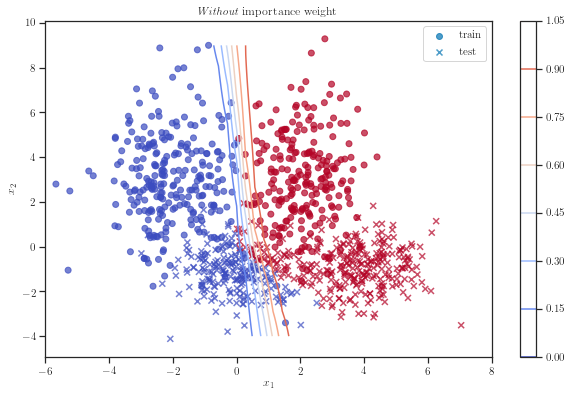

In [128]:
fig, ax = plt.subplots()

ax.set_title(r"\emph{Without} importance weight")

contours = ax.contour(x1, x2, model1.predict(X_q).squeeze(), cmap="coolwarm")

ax.scatter(*X_train.T, c=y_train, cmap="coolwarm", alpha=0.7, label="train")
ax.scatter(*X_test.T, c=y_test, marker='x', cmap="coolwarm", alpha=0.7, label="test")

fig.colorbar(contours, ax=ax)

ax.legend()

ax.set_xlabel(r'$x_1$')
ax.set_ylabel(r'$x_2$')

plt.show()

In [116]:
model2 = build_model(output_dim=1, batch_norm=False)
optimizer2 = Adam()
model2.compile(loss='binary_crossentropy', optimizer=optimizer1,
               metrics=['accuracy'])
# hist2 = model2.fit(X_train, y_train, batch_size=batch_size,
#                    epochs=300, validation_data=(X_test, y_test),
#                    shuffle=True, sample_weight=pair.density_ratio(X_train).numpy())
# hist2 = model.fit(X_train, y_train, batch_size=batch_size,
#                   epochs=300, validation_data=(X_test, y_test),
#                   shuffle=True, )

In [117]:
model2.summary()

ValueError: This model has not yet been built. Build the model first by calling `build()` or calling `fit()` with some data, or specify an `input_shape` argument in the first layer(s) for automatic build.

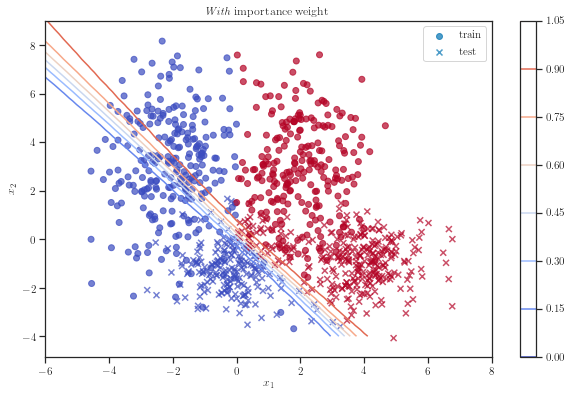

In [111]:
fig, ax = plt.subplots()

ax.set_title(r"\emph{With} importance weight")

contours = ax.contour(x1, x2, model2.predict(X_q).squeeze(), cmap="coolwarm")

ax.scatter(*X_train.T, c=y_train, cmap="coolwarm", alpha=0.7, label="train")
ax.scatter(*X_test.T, c=y_test, marker='x', cmap="coolwarm", alpha=0.7, label="test")

fig.colorbar(contours, ax=ax)

ax.legend()

ax.set_xlabel(r'$x_1$')
ax.set_ylabel(r'$x_2$')

plt.show()

In [403]:
d1 = dict(hist1.history)
d1["name"] = "uniform"

d2 = dict(hist2.history)
d2["name"] = "importance"

In [404]:
data = pd.concat([pd.DataFrame(d1), pd.DataFrame(d2)], axis="index")
data.index.name = "epoch"
data = data.reset_index().set_index(["epoch", "name"])

In [405]:
data.columns.name = "metric"
data

,metric,loss,accuracy,val_loss,val_accuracy
epoch,name,,,,
0,uniform,0.429388,0.984,0.591022,0.822
1,uniform,0.409678,0.984,0.568364,0.832
2,uniform,0.391897,0.984,0.547310,0.840
3,uniform,0.375475,0.986,0.528078,0.846
4,uniform,0.360606,0.986,0.510080,0.848
...,...,...,...,...,...
295,importance,0.078343,0.736,0.063687,0.984
296,importance,0.078358,0.736,0.063636,0.984
297,importance,0.078430,0.736,0.063518,0.984


In [406]:
s = data.stack()
s.name = "value"
s.reset_index()

,epoch,name,metric,value
0,0,uniform,loss,0.429388
1,0,uniform,accuracy,0.984000
2,0,uniform,val_loss,0.591022
3,0,uniform,val_accuracy,0.822000
4,1,uniform,loss,0.409678
...,...,...,...,...
2395,298,importance,val_accuracy,0.984000
2396,299,importance,loss,0.078310
2397,299,importance,accuracy,0.736000
2398,299,importance,val_loss,0.063524


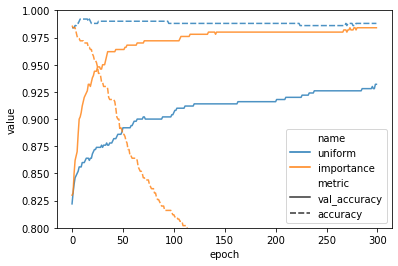

In [408]:
fig, ax = plt.subplots()

sns.lineplot(x="epoch", y="value", hue="name", style="metric", 
             style_order=["val_accuracy", "accuracy"], data=s.reset_index(), alpha=0.8, ax=ax)
# ax.set_yscale("log")
ax.set_ylim(0.8, 1.0)

plt.show()

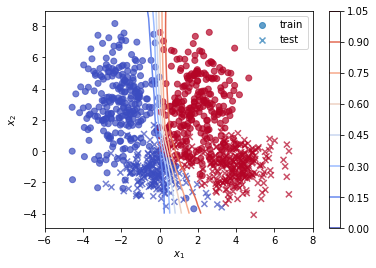

In [409]:
fig, ax = plt.subplots()

contours = ax.contour(x1, x2, model.predict(X_q).squeeze(), cmap="coolwarm")

ax.scatter(*X_train.T, c=y_train, cmap="coolwarm", alpha=0.7, label="train")
ax.scatter(*X_test.T, c=y_test, marker='x', cmap="coolwarm", alpha=0.7, label="test")

fig.colorbar(contours, ax=ax)

ax.legend()

ax.set_xlabel(r'$x_1$')
ax.set_ylabel(r'$x_2$')

plt.show()

In [112]:
model2 = build_model(output_dim=1, batch_norm=False)

In [115]:
model2.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_20 (Dense)             multiple                  24        
_________________________________________________________________
dense_21 (Dense)             multiple                  9         
Total params: 33
Trainable params: 33
Non-trainable params: 0
_________________________________________________________________
